In [1]:
import h5py; import numpy as np; from matplotlib import pyplot as plt; import data_conditioner

## LCLS II Hard X-Ray Front-End Attenuator System:
--------------------------------------------------------------------
### Semi-empirical photo-absorption data pipeline for transmission calculations
*Rajan Plumley, LCLS Experiment Control Systems*

#### Table of Contents
1. [Introduction](#intro)
2. [X-ray transmission review](#review)
3. [CXRO dataset interpolation](#calculations)
4. [Material configuration](#config)
5. [Mass absorption lookup tables](#tables)
6. [Total transmission](#total)


**References:**

_B.L. Henke, E.M. Gullikson, and J.C. Davis, X-ray interactions: photoabsorption, scattering, transmission, and reflection at E=50-30000 eV, Z=1-92, Atomic Data and Nuclear Data Tables 54 no.2, 181-342 (July 1993)._

_B.D. Cullity, Elements of X-Ray Diffraction (Second Edition), 11-20, (1978)._ 

#### Introduction  <a name="intro"></a>

The solid attenuator is used to protect downstream devices from radiation damage by reducing the intensity of the X-FEL beam with a configurable sequence of attenuating filters.  It is also used to precisely tune the intensity of the X-FEL beam to suit experimental needs.  Therefore a well-established and accurate method for approximating X-ray transmission through the filters is needed.

Just as before, we will use the semi-empirical CXRO dataset, [_B.L. Henke, E.M. Gullikson, and J.C. Davis_](http://henke.lbl.gov/optical_constants/asf.html), to calculate the photon energy-dependant transmission through solid filters of arbitrary thickness.  Absorption due to inelastic scattering is not considered.

However -- in contrast to before -- rather than directly sourcing an attenuation length from the CXRO calculators and tables (which assumes parameters that are fixed), the transmissions will be obtained dynamically (but still using the Beer-Lambert relation).  The benefit of this approach is a more "open-box" toolkit for calculations, allowing for adjustment of the physical parameters and a much finer photon energy resolution via interpolation of the original semi-empirical dataset.

This notebook will review these calculations and describe the workings of the `data_conditioner` Python script, which will be used to generate mass absorption lookup tables for the X-FEL transmission calculations. 

#### X-ray transmission review  <a name="review"></a>
The intensity of the transmitted beam is approximated by the Beer-Lambert relation,

$$I = I_0 e^{-\mu d}$$

where $\mu$ is the mass absorption coefficient and $d$ is the linear depth (thickness) of the material that the beam passes through.

The mass absorption coefficient is proportional to the atomic photoabsorption cross-section by Avagadros number $N_A$ and atomic weight $A$.

$$\mu_m = \frac{N_A}{A} \sigma_a$$

http://xdb.lbl.gov/Section1/Sec_1-6.pdf

the atomic photoabsorption cross-section for an element is dependant on the photon wavelength $\lambda$ and the energy-specific atomic scattering factor $f_2$

$$ \sigma_a = 2 r_0 \lambda f_2 $$

http://henke.lbl.gov/optical_constants/intro.html

Using chosen values for the material constants, the transmission can be expressed in terms of the photon wavelength and corresponding atomic scattering factor $f_2$,

$$ T = \frac{I}{I_0} = e^{-\mu d} = e^{-2 r_0 \lambda f_2 \frac{N_A}{A}\rho d}$$

#### CXRO dataset interpolation  <a name="interpolation"></a>

The CXRO dataset provides tables of the semi-empirical atomic scattering factors $f_1$ & $f_2$ and the photon energy (eV) that they were obtained at, spanning a range of 50-30000 eV.  The files are provided in a `.nff` format.  Data for carbon is inspected below.

In [2]:
element = 'C'
cxro = data_conditioner.nff_to_npy(element) # Read the .nff file into a NumPy array.

In [3]:
print("CXRO data for {}, first 10 entries:".format(element)); print("eV"+20*" "+"f1"+20*" "+"f2")
print(cxro[:10])

CXRO data for C, first 10 entries:
eV                    f1                    f2
[[ 1.00000e+01 -9.99900e+03  8.06885e-01]
 [ 1.01617e+01 -9.99900e+03  8.51522e-01]
 [ 1.03261e+01 -9.99900e+03  8.98628e-01]
 [ 1.04931e+01 -9.99900e+03  9.48341e-01]
 [ 1.06628e+01 -9.99900e+03  1.00080e+00]
 [ 1.08353e+01 -9.99900e+03  1.05755e+00]
 [ 1.10106e+01 -9.99900e+03  1.12167e+00]
 [ 1.11886e+01 -9.99900e+03  1.18968e+00]
 [ 1.13696e+01 -9.99900e+03  1.26181e+00]
 [ 1.15535e+01 -9.99900e+03  1.33832e+00]]


This is a great start, but one can quickly see that the points are not evenly sampled.  In fact, some tables for different elements contain a different number of samples altogether.  Due to logarthmic sampling, at hard X-ray energies there can be hundreds of eV difference between samples.  This presents challenge for on-the-fly transmission calculations where a fine photon energy granularity is desired.  The plot below shows the range of samples across photon energies expected during LCLS hard X-ray copper linac operation.

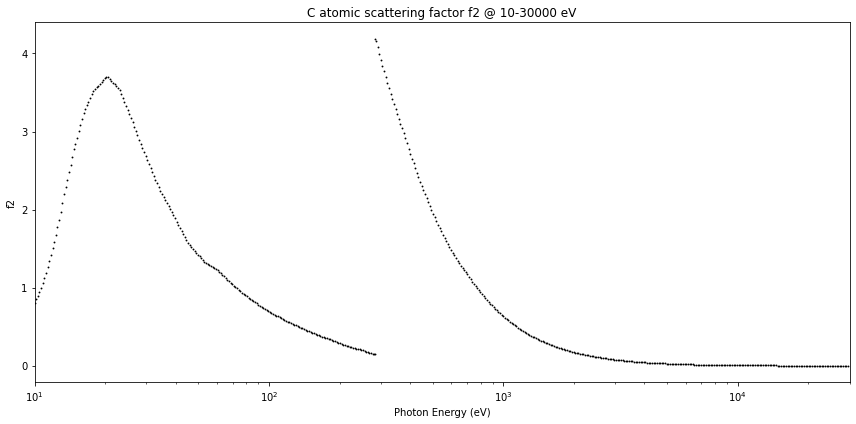

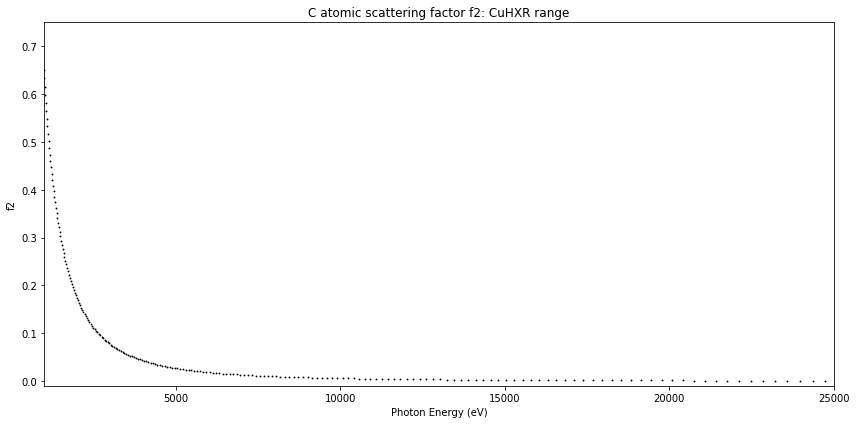

In [4]:
plt.figure(figsize=(12,6));plt.scatter(cxro[:,0],cxro[:,2],s=0.75,c='black'); plt.xscale('log');
plt.xlabel("Photon Energy (eV)");plt.ylabel("f2");plt.xlim(10,30000)
plt.title("{} atomic scattering factor f2 @ 10-30000 eV".format(element));plt.show()
plt.figure(figsize=(12,6));plt.scatter(cxro[:,0],cxro[:,2],s=0.75,c='black'); plt.xscale('linear');
plt.xlabel("Photon Energy (eV)");plt.ylabel("f2");plt.xlim(1000,25000);plt.ylim(-0.01,0.75)
plt.title("{} atomic scattering factor f2: CuHXR range".format(element)); plt.show()

To acquire scattering factors with a higher resolution, `data_conditioner` uses [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) to map the table to a linear mesh in order to reach a desired photon energy resolution `res`.  The plots below show interpolated CXRO data with 0.1 eV resolution. 

In [5]:
cxro_interp = data_conditioner.fill_data_linear('C', (cxro[0,0],cxro[-1,0]), res=10)

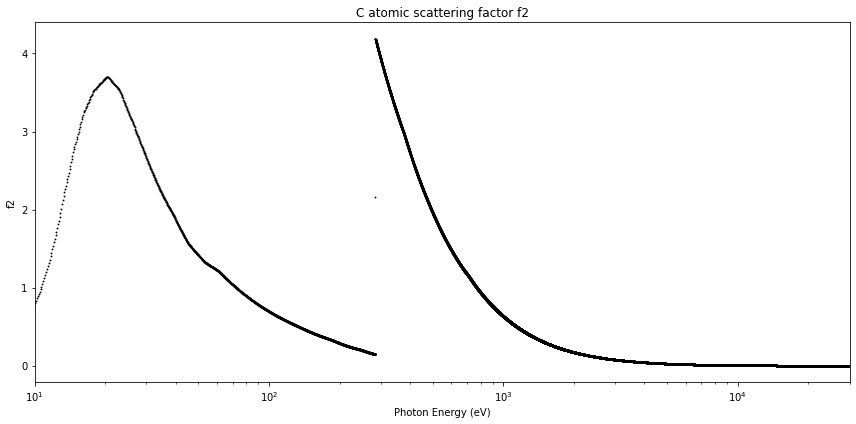

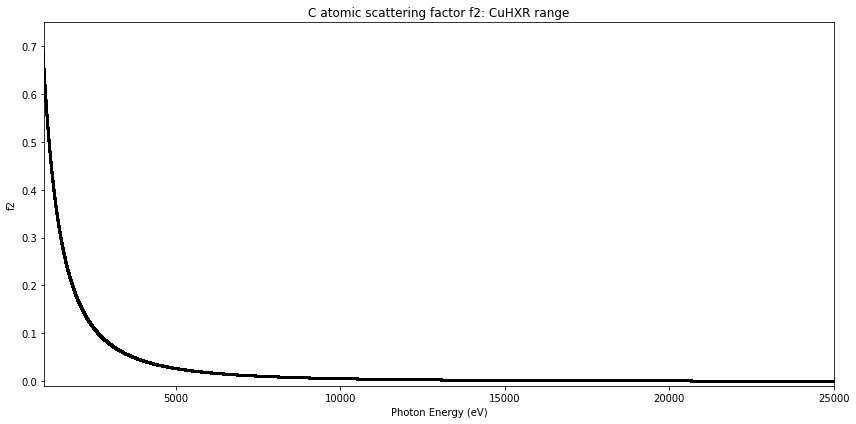

In [6]:
plt.figure(figsize=(12,6))
plt.scatter(np.linspace(10,cxro[-1,0],len(cxro_interp)),cxro_interp,s=0.75,c='black'); plt.xscale('log');
plt.xlabel("Photon Energy (eV)");plt.ylabel("f2");plt.xlim(10,30000)
plt.title("{} atomic scattering factor f2".format(element)); plt.show()
plt.figure(figsize=(12,6))
plt.scatter(np.linspace(10,cxro[-1,0],len(cxro_interp)),cxro_interp,s=2,c='black'); plt.xscale('linear');
plt.xlabel("Photon Energy (eV)");plt.ylabel("f2");plt.xlim(1000,25000);plt.ylim(-0.01,0.75)
plt.title("{} atomic scattering factor f2: CuHXR range".format(element)); plt.show()

#### Material configuration  <a name="config"></a>

When invoked, `data_conditioner` will generate `HDF5` files of photon energies (eV), and their corresponding $f_2$ and $\mu$ based on material data specified in configurable Python dictionaries.  This way, LCLS SRD has license to select and change which physical parameter values are chosen for their filter materials. (Physical constants such as speed of light, classical electron radius etc. are also configurable but not shown in this notebook)

In [7]:
C_data = {    
    'formula'      : 'C',        # Carbon
    'atomic_number': 6,          # Z
    'atomic_weight': 12.01,      # grams
    'density'      : 3.51E6,     # grams/m^3
}

In [8]:
C_T_data = data_conditioner.abs_data(C_data, (50,25000)) # Generate interpolated table of eV, f2, \mu

The solid attenuator control program will load the data file and use them for transmission calculations.  The plots below show transmissions through the Hard X-ray solid attenuator's carbon and silicon filters with 0.1 eV resolution obtained using data generated by the `data_conditioner` Python script.

In [9]:
def plot_T(data, thickness):
    plt.plot(data[:,0],np.exp(-data[:,2]*thickness),label="{} um".format(thickness*1E6));

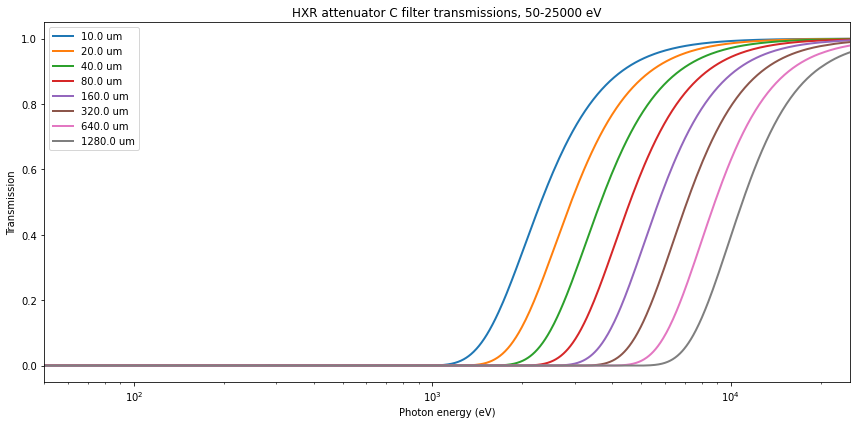

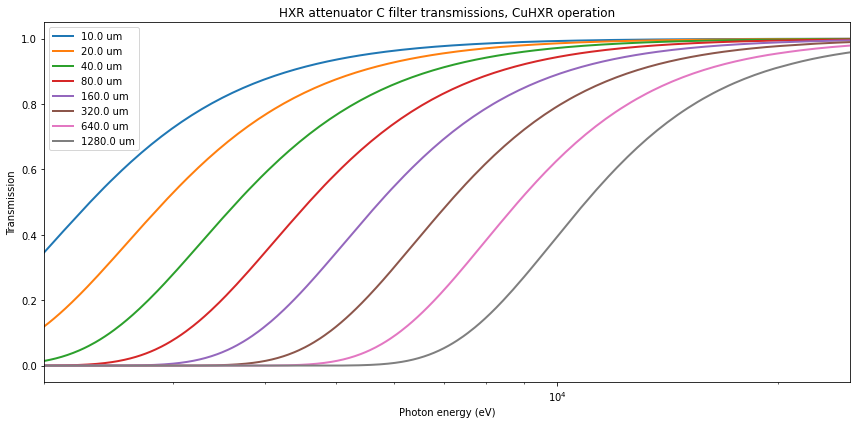

In [10]:
plt.figure(figsize=(12,6))
for i in [10, 20, 40, 80, 160, 320, 640, 1280]:
    plot_T(C_T_data, i*1E-6)
plt.ylabel("Transmission");plt.xlabel("Photon energy (eV)");plt.xscale('log');plt.xlim(50,25000);
plt.legend();plt.title("HXR attenuator C filter transmissions, 50-25000 eV");plt.show()
plt.figure(figsize=(12,6))
for i in [10, 20, 40, 80, 160, 320, 640, 1280]:
    plot_T(C_T_data, i*1E-6)
plt.ylabel("Transmission");plt.xlabel("Photon energy (eV)");plt.xscale('log');plt.xlim(2000,25000);
plt.legend();plt.title("HXR attenuator C filter transmissions, CuHXR operation");plt.show()

In [12]:
Si_data = {
    'formula'      : 'Si',       # Silicon
    'atomic_number': 14,         # Z
    'atomic_weight': 28.0855,    # grams
    'density'      : 2.329E6,    # grams/m^3
}
Si_T_data = data_conditioner.abs_data(Si_data, (50,25000)) # Generate interpolated table of eV, f2, \mu

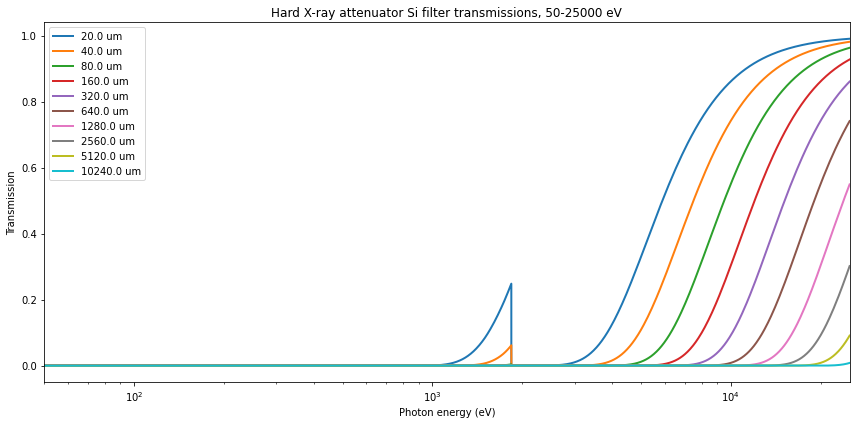

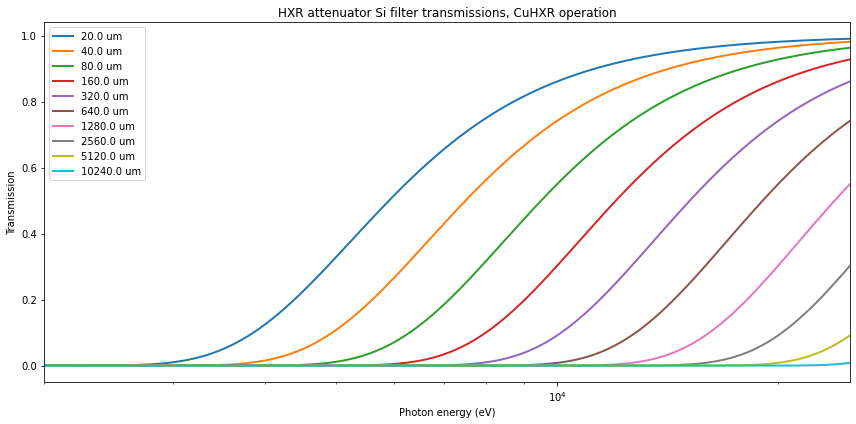

In [13]:
plt.figure(figsize=(12,6))
for i in [20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]:
    plot_T(Si_T_data, i*1E-6)
plt.ylabel("Transmission");plt.xlabel("Photon energy (eV)");plt.xscale('log');plt.xlim(50,25000);
plt.legend();plt.title("Hard X-ray attenuator Si filter transmissions, 50-25000 eV");plt.show()
plt.figure(figsize=(12,6))
for i in [20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]:
    plot_T(Si_T_data, i*1E-6)
plt.ylabel("Transmission");plt.xlabel("Photon energy (eV)");plt.xscale('log');plt.xlim(2000,25000);
plt.legend();plt.title("HXR attenuator Si filter transmissions, CuHXR operation");plt.show()

#### Total transmission  <a name="total"></a>

The exponential formula for transmission makes calculating the total transmission through the total sequence of filters straight-forward.  To consider filter in/out states, let $\delta_i = 1$ if the $i^{th}$ filter is inserted and $\delta_i = 0$ if the $i^{th}$ filter is retracted.

$$ T_{tot} = e^{\sum_i -\delta_i \mu_i d_i} = e^{-\delta_1 \mu_1 d_1}e^{-\delta_2 \mu_2 d_2} \dots e^{-\delta_N \mu_N d_N} = \prod_i T_i (\delta_{i})$$

An equivalent operation is implemented in Python below.  Consider a pretend filter configuration comprised of simple 'IN' and 'OUT' states:

In [16]:
fake_config = [1, 1, np.nan, 1, np.nan, 1, np.nan, np.nan]
print("Pretend filter In/Out configuration (1: 'IN', nan: 'OUT')\n");print(fake_config)

fake_config2 = [1, 1, 0, 1, 0, 1, 0, 0]

Pretend filter In/Out configuration (1: 'IN', nan: 'OUT')

[1, 1, nan, 1, nan, 1, nan, nan]


In Python, it is convenient to represent the 'OUT' states as `NaN` -- Not a Number.  The filter transmissions are matrix-multiplied by the "in/out configuration mask" and the total transmission is its non-`NaN` product.  Numpy has a fast and easy method for this called `nanprod()`.

$$ \boldsymbol{T} = \begin{bmatrix}
T_1 & T_2 & T_4 & T_5 & T_6 & T_7 & T_8 \\
\end{bmatrix} \times
\begin{bmatrix}
1 \\ 1 \\ \text{NaN} \\ 1 \\ \text{NaN} \\ 1 \\ \text{NaN} \\ \text{NaN}
\end{bmatrix} = 
\begin{bmatrix}
T_1 \\ T_2 \\ \text{NaN} \\ T_4 \\ \text{NaN} \\ T_6 \\ \text{NaN} \\ \text{NaN}
\end{bmatrix},
$$

$$ T_{tot} = \prod_{T \neq \text{NaN}} \boldsymbol{T} $$

In [18]:
eV_index = 95000; thicknesses = np.asarray([10, 20, 40, 80, 160, 320, 640, 1280])*1E-6
T_vals = np.exp(-C_T_data[eV_index,2]*thicknesses)
T_vals2 = np.exp(-C_T_data[eV_index,2]*thicknesses*fake_config2)
print("Total transmission at {0} eV:  {1}".format(C_T_data[eV_index,0],np.nanprod(T_vals*fake_config)))
print("Total transmission at {0} eV:  {1}".format(C_T_data[eV_index,0],np.prod(T_vals2)))

Total transmission at 9550.0 eV:  0.696084083669176
Total transmission at 9550.0 eV:  0.696084083669176


This style of operation may seem peculiar, but it becomes useful when evaluating the transmission over large configuration spaces because it is fast and does not rely on iteration.  This way, the attenuator program can evaluate the total transmission of all $2^{18}$ different filter configurations in milliseconds!